# Title

This Notebook...

## Initialization

### Imports

In [1]:
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(message)s')

import numpy
import matplotlib.pyplot

import sys
sys.path.append("../")
import congestionfinder
import congestionfinder.bpsdetector
import congestionfinder.road
import congestionfinder.detection
import congestionfinder.speedflow
import congestionfinder.congestion
import patchfinder.patches

## Classes

In [2]:
bpsDetector = congestionfinder.bpsdetector.BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


In [3]:
road = congestionfinder.road.Road(12)
road.addBPSDetector(bpsDetector)
print(road)
road.indexDetectorSpaces()
print(road.getSpaceToSpaceIndex())

roadNumber: 12 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 0
{20891: 0}


In [4]:
detection = congestionfinder.detection.Detection("00D00C03405B18200005", 1234, 1440, 120, 17)
print(detection)

code: 00D00C03405B18200005 | space: 1234 | time: 1440 | speed: 120 | flow: 17


## Roads

In [5]:
roads = congestionfinder.road.parseBPSCodesToRoads(["10D00204D037D007000B", "10D002051800D0070013", "10D002057000D007000F"])
for value in roads.values():
    value.indexDetectorSpaces

2017-12-11 10:44:19,964 Starting parseBPSCodesToRoads()
2017-12-11 10:44:19,964 Ending parseBPSCodesToRoads()


In [6]:
for value in sorted(roads.values(), key = lambda x:len(x.getBPSDetectors())):
    print(value)

roadNumber: 2 | len(bpsDetectors): 3 | len(spaceToSpaceIndex): 3


## Speed and Flows

In [7]:
detections = []
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 1, 80, 17))
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 2, 70, 16))
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 3, 75, 17))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 1, 40, 10))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 2, 55, 18))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 3, 35, 12))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 1, 70, 19))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 2, 85, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 3, 100, 19))

In [8]:
speeds, flows, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex = congestionfinder.speedflow.parseDetectionsToSpeedsAndFlows(detections, roads[2])

2017-12-11 10:44:20,026 Starting parseDetectionsToSpeedFlows()
2017-12-11 10:44:20,026 Ending parseDetectionsToSpeedFlows()


(3, 3)
(3, 3)
0
2
1
3


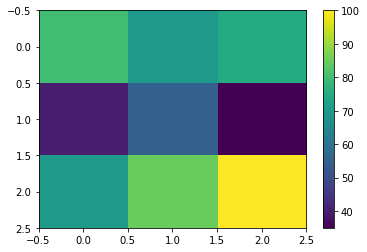

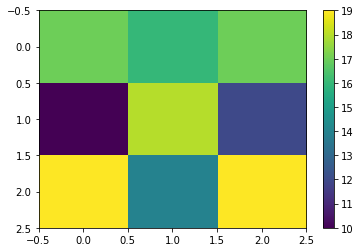

In [9]:
print(speeds.shape)
print(flows.shape)
print(minSpaceIndex)
print(maxSpaceIndex)
print(minTimeIndex)
print(maxTimeIndex)
matplotlib.pyplot.imshow(speeds, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flows, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [10]:
speedsHighFlow, flowsHighFlow, maskHighFlow = congestionfinder.speedflow.removeLowFlowTimes(speeds, flows) ## Do something with Mask

2017-12-11 10:44:20,558 Starting removeLowFlowTimes()
2017-12-11 10:44:20,558 Ending removeLowFlowTimes()


(3, 3)
(3, 3)
1.0


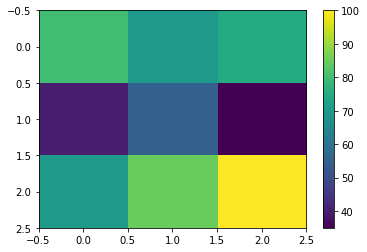

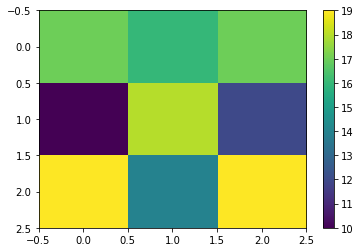

In [11]:
print(speedsHighFlow.shape)
print(flowsHighFlow.shape)
print(sum(maskHighFlow) / (sum(maskHighFlow) + sum(~maskHighFlow)))
matplotlib.pyplot.imshow(speedsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [12]:
speedsWorkingDetectors, flowsWorkingDetectors, maskWorkingDetectors = congestionfinder.speedflow.removeMissingDetectors(speeds, flows) ## Do something with Mask

2017-12-11 10:44:21,042 Starting removeMissingDetectors()
2017-12-11 10:44:21,042 Ending removeMissingDetectors()


(3, 3)
(3, 3)
1.0


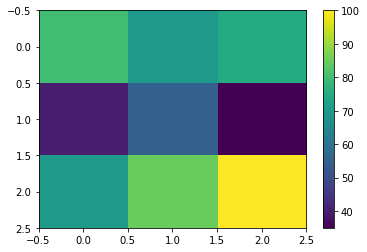

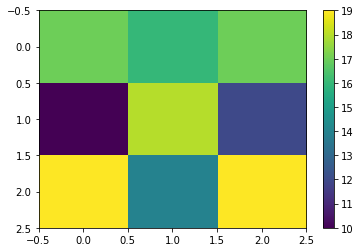

In [13]:
print(speedsWorkingDetectors.shape)
print(flowsWorkingDetectors.shape)
print(sum(maskWorkingDetectors) / (sum(maskWorkingDetectors) + sum(~maskWorkingDetectors)))
matplotlib.pyplot.imshow(speedsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion

In [14]:
congestions = congestionfinder.congestion.parseSpeedFlowsToCongestions(speedsWorkingDetectors, flowsWorkingDetectors)

2017-12-11 10:44:21,573 Starting parseSpeedFlowsToCongestions()
2017-12-11 10:44:21,573 Ending parseSpeedFlowsToCongestions()


(3, 3)


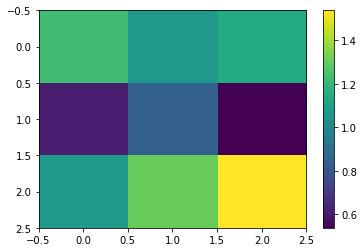

In [15]:
print(congestions.shape)
matplotlib.pyplot.imshow(congestions, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [16]:
congestionsWithoutMissingValues = congestionfinder.congestion.interpolateMissingValues(congestions)

2017-12-11 10:44:21,808 Starting interpolateMissingValues()
2017-12-11 10:44:21,808 Ending interpolateMissingValues()


(3, 3)


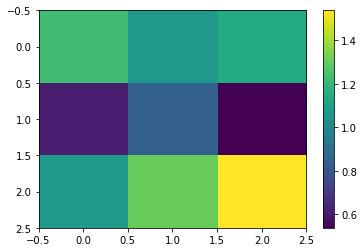

In [17]:
print(congestionsWithoutMissingValues.shape)
matplotlib.pyplot.imshow(congestionsWithoutMissingValues, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [18]:
congestionsSmoothed = congestionfinder.congestion.applySmoothingFilter(congestionsWithoutMissingValues)

2017-12-11 10:44:22,058 Starting applySmoothingFilter()
2017-12-11 10:44:22,058 Ending applySmoothingFilter()


(3, 3)


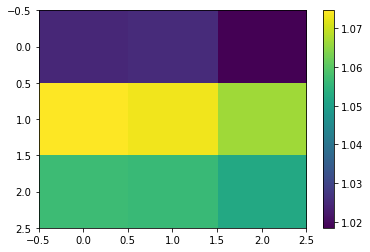

In [19]:
print(congestionsSmoothed.shape)
matplotlib.pyplot.imshow(congestionsSmoothed, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion Filter

In [39]:
testDataArray = numpy.random.rand(16,9)
testBooleanArray = testDataArray >= 0.9
print(testBooleanArray)

[[False False False  True False False  True False False]
 [False False False False False False False False False]
 [ True False False False False False False False False]
 [False False False False False False  True False False]
 [False False False False False False False False  True]
 [False False False False False False False  True False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False  True False False False False False False]
 [False False  True False False False False False False]
 [False False False False False False False False False]]


In [40]:
patches = patchfinder.patches.Patches(testBooleanArray)

2017-12-11 10:46:08,103 Starting patchFinder()
2017-12-11 10:46:08,103 Direction: 0
2017-12-11 10:46:08,103 Starting scanForBoundaries()
2017-12-11 10:46:08,103 Found start: 0
2017-12-11 10:46:08,103 Found stop: 0
2017-12-11 10:46:08,103 Found start: 2
2017-12-11 10:46:08,103 Found stop: 3
2017-12-11 10:46:08,103 Found start: 6
2017-12-11 10:46:08,119 Found stop at end.
2017-12-11 10:46:08,119 Ending scanForBoundaries()
2017-12-11 10:46:08,119 length: 3| parentLength: 0
2017-12-11 10:46:08,119 Scanning children...
2017-12-11 10:46:08,119 Child: 0
2017-12-11 10:46:08,119   Starting patchFinder()
2017-12-11 10:46:08,119   Direction: 1
2017-12-11 10:46:08,119   Starting scanForBoundaries()
2017-12-11 10:46:08,119   Found start: 2
2017-12-11 10:46:08,119   Found stop: 2
2017-12-11 10:46:08,119   Ending scanForBoundaries()
2017-12-11 10:46:08,119   length: 1| parentLength: 3
2017-12-11 10:46:08,135   Scanning children...
2017-12-11 10:46:08,135   Child: 0
2017-12-11 10:46:08,135     Startin

In [41]:
testBoundariesList = patches.getPatches()

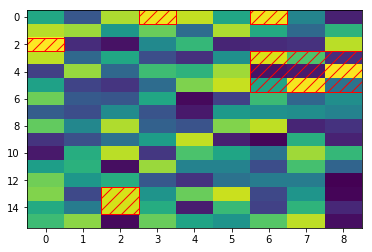

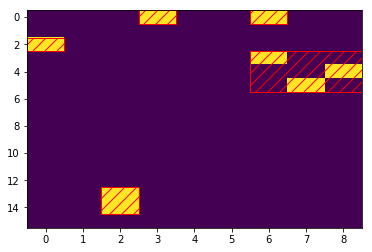

In [42]:
congestionfinder.congestion.plotCongestionsWithBoundaries(testDataArray, testBoundariesList)
congestionfinder.congestion.plotCongestionsWithBoundaries(testBooleanArray, testBoundariesList)

In [43]:
print(testBoundariesList)

[[2, 2, 0, 0], [0, 0, 3, 3], [13, 14, 2, 2], [0, 0, 6, 6], [3, 5, 6, 8]]


In [44]:
testBoundariesListFiltered = congestionfinder.congestion.filterLargeCongestions(testBoundariesList, 1)

2017-12-11 10:46:12,662 Starting filterLargeCongestions()
2017-12-11 10:46:12,662 Ending filterLargeCongestions()


In [49]:
print(testBoundariesListFiltered)

[[0, 2, 1, 3]]


In [50]:
testBoundariesListWithMargins = congestionfinder.congestion.addMargins(testBoundariesListFiltered, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex)

In [51]:
print(congestionBoundariesListWithMargins)

[[0, 2, 1, 3]]


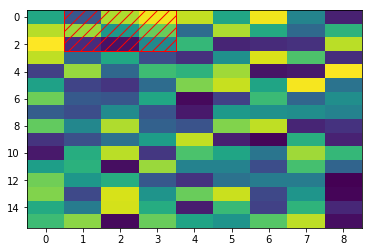

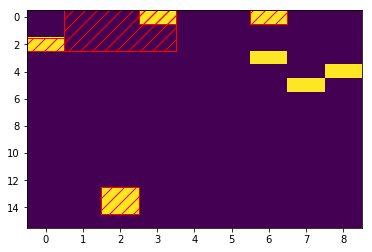

In [48]:
congestionfinder.congestion.plotCongestionsWithBoundaries(testDataArray, testBoundariesListWithMargins)
congestionfinder.congestion.plotCongestionsWithBoundaries(testBooleanArray, testBoundariesList)

End of Notebook